In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits
from nxontology import NXOntology

#!pip install pandas-profiling[notebook]==2.10.1
from pandas_profiling import ProfileReport

#from ontoma import OnToma
#otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
# globals
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
#efo_data = 'data/efo_data.txt.gz'
efo_nodes = 'data/epigraphdb_efo_nodes.csv'
efo_rels = 'data/epigraphdb_efo_rels.csv'
nxontology_measure = 'batet'

modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
]

pallete="hls"

In [3]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#drop cases where query and id are the same
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI  
0  EFO_0004264, EFO_0009431  
1               EFO_0004616  
2               EFO_0003778  
3               EFO_0003901  
4               EFO_0004247  
(1565, 3)
(1613, 3)
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4       

In [4]:
%%time

# get EFO node data
efo_node_df = pd.read_csv(efo_nodes)
efo_node_df.rename(columns={'efo.value':'efo_label','efo.id':'efo_id'},inplace=True)
#drop type
efo_node_df.drop('efo.type',inplace=True,axis=1)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                      efo_label  \
0                 Xeroderma pigmentosum variant   
1                         Xeroderma pigmentosum   
2                               Ischemic stroke   
3                             Cerebral ischemia   
4                          small cell carcinoma   
...                                         ...   
25385         Acetazolamide-responsive myotonia   
25386  Complete androgen insensitivity syndrome   
25387                Intermediate DEND syndrome   
25388                              Epiblepharon   
25389              Congenital eyelid retraction   

                                          efo_id  
0       http://www.orpha.net/ORDO/Orphanet_90342  
1         http://www.orpha.net/ORDO/Orphanet_910  
2      http://purl.obolibrary.org/obo/HP_0002140  
3      http://purl.obolibrary.org/obo/HP_0002637  
4           http://www.ebi.ac.uk/efo/EFO_0008524  
...                                          ...  
25385   http://www.orpha.net/O

In [5]:
#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['efo_id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing))

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 21
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431  
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901  
(1579, 4)


In [6]:
# preprocess
process_text=[]
for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
    params={'text_list':list(g['query'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
ebi_df.loc[:, 'processed'] = process_text
print(ebi_df.head())

1579
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  
0           vascular disorders of intestine  
1           vascular disorders of intestine  
2                              gonarthrosis  
3  psoriatic and enteropathic arthropathies  
4

In [7]:
%%time

f='output/ebi-ukb-vec.tsv.gz'
if os.path.exists(f):
    print('Already done, reading',f)
    ebi_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    for m in modelData:
        ebi_df[m['name']] = ebi_df[m['name']].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    for m in modelData:    
        ebi_df = encode_traits(trait_df=ebi_df,col='processed',name=m['name'],model=m['model'])
    ebi_df.to_csv(f,sep='\t',compression='gzip',index=False)

print(ebi_df.head())
print(ebi_df.shape)

Already done, reading output/ebi-ukb-vec.tsv.gz
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  \
0           vascular disorders of intestine   
1           vascular disorders of intestine   
2                              gonarthrosis   


In [8]:
%%time

# takes ~30 mins for each BERT based model

#test
#efo_node_df = efo_node_df.head(n=5000)

f='output/efo-vec.tsv.gz'
if os.path.exists(f):
    print('Already done, reading',f)
    efo_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    for m in modelData:
        efo_df[m['name']] = efo_df[m['name']].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    for m in modelData:    
        efo_df = encode_traits(trait_df=efo_node_df,col='efo_label',name=m['name'],model=m['model'])
    efo_df.to_csv(f,sep='\t',compression='gzip',index=False)    
print(efo_df.head())


Already done, reading output/efo-vec.tsv.gz
                       efo_label                                     efo_id  \
0  Xeroderma pigmentosum variant   http://www.orpha.net/ORDO/Orphanet_90342   
1          Xeroderma pigmentosum     http://www.orpha.net/ORDO/Orphanet_910   
2                Ischemic stroke  http://purl.obolibrary.org/obo/HP_0002140   
3              Cerebral ischemia  http://purl.obolibrary.org/obo/HP_0002637   
4           small cell carcinoma       http://www.ebi.ac.uk/efo/EFO_0008524   

                                          BioSentVec  \
0  [-0.045969586819410324, 0.5196870565414429, -0...   
1  [0.01842655800282955, 0.7100013494491577, -0.7...   
2  [0.5974032282829285, -0.6174705028533936, -0.1...   
3  [0.46593865752220154, -0.6334501504898071, 0.0...   
4  [0.4248107373714447, 0.033654093742370605, 0.3...   

                                             BioBERT  \
0  [-0.2842123508453369, 0.22479310631752014, 0.1...   
1  [-0.34557363390922546, 0.2918

In [9]:
# Google Universal Sentence Encoder

!pip install -q "tensorflow>=2.0.0"
!pip install -q --upgrade tensorflow-hub

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [10]:
# create GUSE encodings for EBI and EFO
%time 

guse_ebi_embeddings = embed(ebi_df['processed'])
guse_efo_embeddings = embed(efo_df['efo_label'])

guse_ebi_embeddings_list = []
for g in guse_ebi_embeddings:
    guse_ebi_embeddings_list.append(g.numpy())
ebi_df['GUSE']=guse_ebi_embeddings_list

guse_efo_embeddings_list = []
for g in guse_efo_embeddings:
    guse_efo_embeddings_list.append(g.numpy())
efo_df['GUSE']=guse_efo_embeddings_list

print(ebi_df.head())

modelData.append({'name':'GUSE','model':'GUSEv4'})

#print(len(guse_ebi_embeddings), guse_ebi_embeddings[0].numpy())
#print(len(guse_efo_embeddings), guse_efo_embeddings[0].numpy().shape)
#guse_corr = np.inner(guse_ebi_embeddings, guse_efo_embeddings)

#print(len(corr[0]))
#np.save('output/guse-dd.npy',guse_corr)
#a=np.load('output/guse-dd.npy')
#print(len(a))

# add to ebi_df
#ebi_df['guse']=guse_ebi_embeddings
#print(ebi_df.head())

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 28.1 µs
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   

                                  processed  \
0           vascular disorders of intestine   
1           vascular disorders of intestine   
2                              

In [11]:
#create nxontology network of EFO relationships
def create_efo_nxo() -> NXOntology:
    nxo = NXOntology()
    
    edges = []
    efo_rel_df=pd.read_csv(efo_rels)
    for i,row in efo_rel_df.iterrows():
        child = row['efo.id']
        parent = row['parent_efo.id']
        edges.append((parent,child))
    #print(edges[0:10])
    nxo.graph.add_edges_from(edges)
    return nxo

efo_nx = create_efo_nxo()
efo_nx.freeze()

In [12]:
def run_pairs(model):
    dd_name = f"output/{model}-dd.npy"
    
    v1 = list(ebi_df[model])
    v2 = list(efo_df[model])
    
    if os.path.exists(dd_name):
        print(dd_name,'already created, loading...')
        with open(dd_name, 'rb') as f:
            dd = np.load(f)
    else:    
        # cosine of lists
        dd = create_pair_distances(v1,v2)
        np.save(dd_name,dd)
    print('done')
    return dd

def write_to_file(model,pairwise_data):
    fo = gzip.open(f'output/{model}-pairwise.tsv','w')
    ebi_efo_list = ebi_df['full_id']
    efo_list = efo_df['efo_id']
    for i in range(0,len(ebi_efo_list)):
        # write to file
        mCount=0
        for j in range(i,len(efo_list)):
            if i != j:
                #print(ids[i],ids[j],1-pws[mCount])
                score = 1-pairwise_data[i][j]
                fo.write(f"{ebi_efo_list[i]}\t{efo_list[j]}\t{score}\n")
                mCount+=1
                
def get_top(model,pairwise_data):
    count=0
    dis_results=[]
    efo_map = []
    cosine_results = []
    manual_pos_results = []
    for manual_efo in ebi_df['full_id']:
        predicted_efo = None
        #min_val = 0
        min_val=None
        manual_dis_loc=None
        nx_val=None
        cosine_val=None
        
        #skip encodings with just zeros
        if np.count_nonzero(ebi_df.iloc[count][model])>0:
            #print('Empty encoding',ebi_df.iloc[count][model])
            
            # find the EFO term with minumum distance
            min_dis = np.nanargmin(pairwise_data[count])
            min_val = np.nanmin(pairwise_data[count])
            cosine_val = 1-min_val

            predicted_efo = efo_df.iloc[min_dis]['efo_id']
            #efo_map.append(predicted_efo)

            # find the location of the 'correct' EFO term and get ordered position 
            manual_loc = efo_df[efo_df['efo_id'] == manual_efo].index[0]
            manual_dis = pairwise_data[count][manual_loc]
            
            #print(manual_dis)
            # create sorted list of cosines to find position of manual mapped EFO
            # deal with nan too
            sorted_dis = sorted([x for x in pairwise_data[count] if str(x) != 'nan'])
            manual_dis_loc = sorted_dis.index(manual_dis)
            

            #run nxontology similarity
            res = similarity = efo_nx.similarity(manual_efo,predicted_efo).results()
            nx_val = res[nxontology_measure]
            
        manual_pos_results.append(manual_dis_loc)
        dis_results.append(nx_val)    
        cosine_results.append(cosine_val)
        efo_map.append(predicted_efo)
        count+=1
        
    ebi_df[f'{model}-nx']=dis_results
    ebi_df[f'{model}-efo']=efo_map
    ebi_df[f'{model}-cosine']=cosine_results
    ebi_df[f'{model}-rank']=manual_pos_results
    #print(ebi_df.head())
    print(model,'greater than 0.9:',ebi_df[ebi_df[f'{model}-nx']>0.9].shape)
    
    #plot histogram of distances
    sns_plot = sns.displot(ebi_df, x=f"{model}-nx",kde=True)
    sns_plot.savefig(f"output/{model}-{nxontology_measure}-nx.pdf")
    
    #plot correlation between cosine and nxontolgy
    sns_rel = sns.relplot(data=ebi_df, x=f'{model}-nx', y=f'{model}-cosine')
    sns_rel.savefig(f"output/{model}-nx-vs-cosine.pdf")
    
    #plot histogram of correct EFO location
    sns_plot = sns.displot(ebi_df, x=f"{model}-rank", kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
    sns_plot.savefig(f"output/{model}-rank.pdf")

#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)
#for m in modelData:
#    dd = run_pairs(m['name'])
#    get_top(m['name'],dd)    

#print(ebi_df.head())

BioSentVec
output/BioSentVec-dd.npy already created, loading...
done
BioSentVec greater than 0.9: (811, 13)
BioBERT
output/BioBERT-dd.npy already created, loading...
done
BioBERT greater than 0.9: (706, 17)
BlueBERT
output/BlueBERT-dd.npy already created, loading...
done
BlueBERT greater than 0.9: (695, 21)
GUSE
output/GUSE-dd.npy already created, loading...
done
GUSE greater than 0.9: (671, 25)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0009431  http://www.ebi.ac.uk/efo/EFO_0009431   
2  EFO

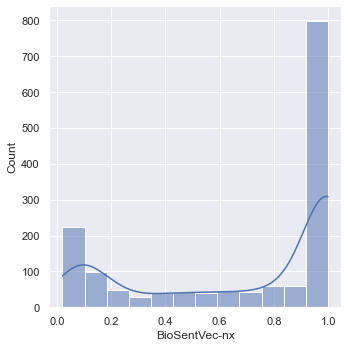

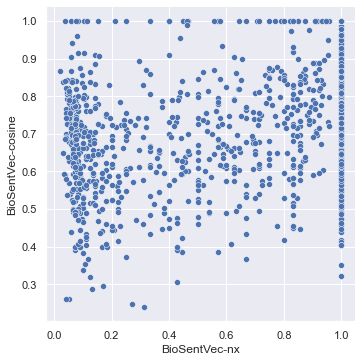

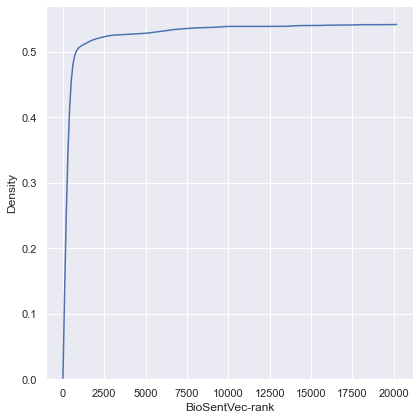

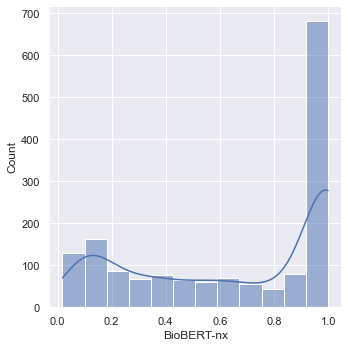

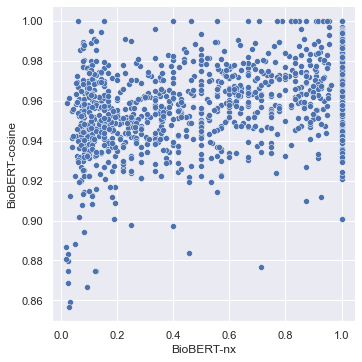

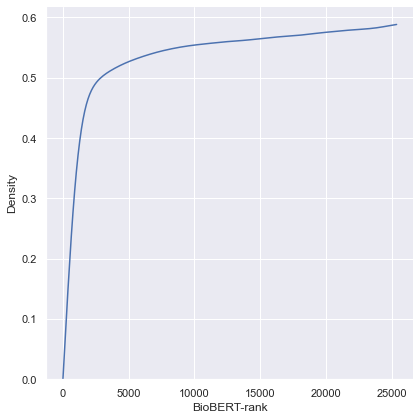

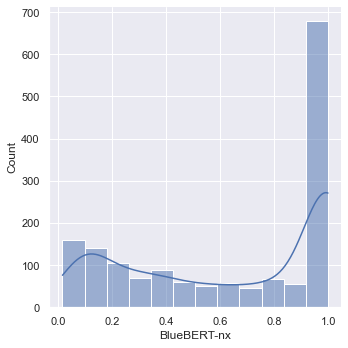

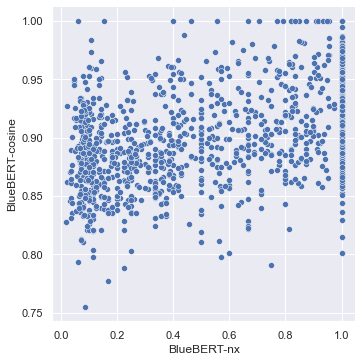

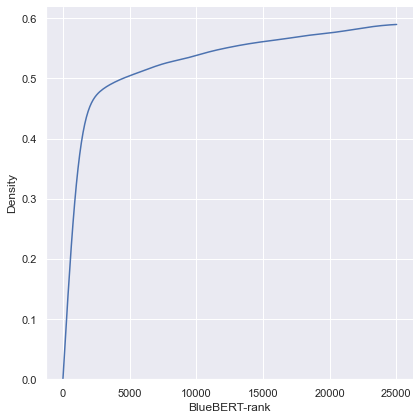

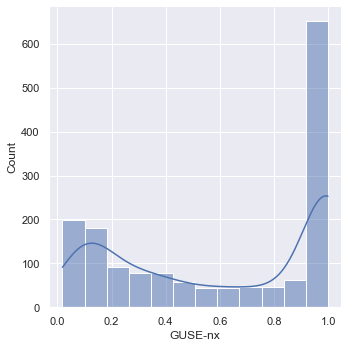

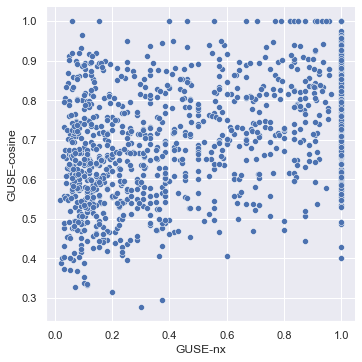

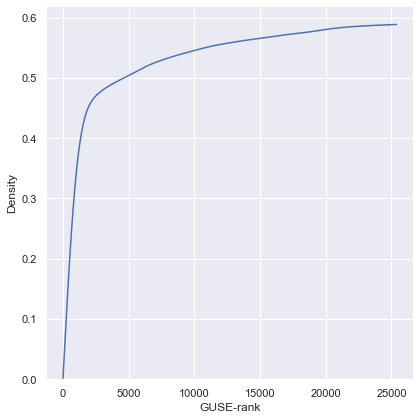

In [13]:
%%time
#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)

#get_top('BioSentVec',dd)
for m in modelData:
    print(m['name'])
    dd = run_pairs(m['name'])
    get_top(m['name'],dd)    
    

print(ebi_df.head())
print(ebi_df.describe())
print(ebi_df.shape)

In [14]:
# ontoma 
# print(otmap.find_term('Vascular disorders of intestine'))
# think this is just using zooma

In [15]:
# zooma using web app
# ran the web app using filtered list of terms
# Configure Data Sources - Don't search in any datasources checked
# Configure Ontology Sources - EFO
# https://www.ebi.ac.uk/spot/zooma

#zooma_df = pd.read_csv('data/zooma.tsv',sep='\t')
#zooma_df['zooma_efo'] = zooma_df['ONTOLOGY(S)']+zooma_df['ONTOLOGY TERM(S)']
#zooma_df.drop_duplicates(subset=['zooma_efo'],inplace=True)
#print(zooma_df.shape)

In [16]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(text,res[0]['semanticTags'])
        return res[0]['semanticTags'][0]
    else:
        return 'NA'

In [ ]:
%%time

# takes around 3 minutes for 1,000
f='output/ebi-zooma-api.tsv'
if os.path.exists(f):
    ebi_df_zooma = pd.read_csv(f,sep='\t')
else:
    ebi_df_zooma = ebi_df
    ebi_df_zooma['zooma_api'] = ebi_df_zooma['query'].apply(lambda x:run_zooma(x))
    ebi_df_zooma.to_csv('output/ebi-zooma-api.tsv',sep='\t',index=False)
print(ebi_df_zooma.head())
print(ebi_df_zooma.shape)

1579
(740, 26)


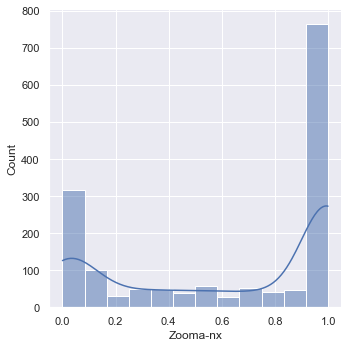

In [18]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
for i, row in ebi_df_zooma.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['zooma_api'],row['full_id']).results()
        dis_results.append(res[nxontology_measure])
    except:
        dis_results.append(0)
        
print(len(dis_results))
ebi_df['Zooma-nx'] = dis_results
print(ebi_df[ebi_df['Zooma-nx']>0.99].shape)
ebi_df.to_csv('output/ebi-nx.tsv',sep='\t',index=False)
sns.displot(ebi_df, x="Zooma-nx",kde=True)

  efo_term                                 ukbb_trait     score  \
0     pain                  Abdominal and pelvic pain  1.555694   
1     pain  Chest pain felt outside physical activity  2.116430   
2     pain                 General pain for 3+ months  2.966705   
3     pain                                       Pain -0.329808   
4     pain           Pain associated with micturition  2.598001   

                        BERT-EFO-efo-id  
0  http://www.ebi.ac.uk/efo/EFO_0003843  
1  http://www.ebi.ac.uk/efo/EFO_0003843  
2  http://www.ebi.ac.uk/efo/EFO_0003843  
3  http://www.ebi.ac.uk/efo/EFO_0003843  
4  http://www.ebi.ac.uk/efo/EFO_0003843  
(1516, 4)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     pso

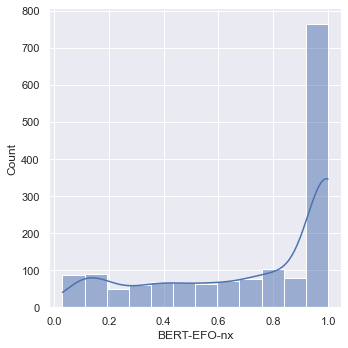

In [19]:
# BERT-EFO

def bert_efo():
    bef_df = pd.read_csv('data/bluebert_efo_mapping.csv')
    bef_df.rename(columns={'efo_id':'BERT-EFO-efo-id'},inplace=True)
    print(bef_df.head())
    print(bef_df.shape)

    # merge with ebi_df
    ebi_df_merge = pd.merge(ebi_df,bef_df,left_on='query',right_on='ukbb_trait')
    print(ebi_df_merge.head())

    dis_results=[]
    name = 'BERT-EFO-nx'
    for i, row in ebi_df_merge.iterrows():
        res = similarity = efo_nx.similarity(row['BERT-EFO-efo-id'],row['full_id']).results()
        dis_results.append(res[nxontology_measure])


    print(len(dis_results))
    ebi_df_merge[name] = dis_results
    print(ebi_df_merge.head())
    print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']>0.9].shape)
    ebi_df_merge.to_csv('output/ebi-nx.tsv',sep='\t',index=False)
    sns.displot(ebi_df_merge, x=name,kde=True)
    return ebi_df_merge
ebi_df_merge=bert_efo()
print(ebi_df_merge.shape)

In [20]:
print(ebi_df_merge.shape)
def add_bert_ranks():
    df = pd.read_csv('data/bluebert_efo_rankings.csv')
    print(df.head())
    m = pd.merge(ebi_df_merge,df[['ukbb_trait','ranking']],left_on='ukbb_trait',right_on='ukbb_trait')
    m.rename(columns={'ranking':'BERT-EFO-rank'},inplace=True)
    print(m.head())
    return m
ebi_df_merge = add_bert_ranks()
print(ebi_df_merge.shape)
ebi_df_merge.drop_duplicates(subset=['query','full_id'],inplace=True)
print(ebi_df_merge.shape)

(1579, 31)
          efo_term                        ukbb_trait     score  ranking  \
0             pain                         Dorsalgia  3.289763       14   
1             pain                              Pain -0.329808        0   
2             pain          Pain in throat and chest  1.663443        0   
3  sign or symptom  Other general symptoms and signs  6.648379     4419   
4     chronic pain        General pain for 3+ months  3.460647        1   

                                      efo_id  
0       http://www.ebi.ac.uk/efo/EFO_0003843  
1       http://www.ebi.ac.uk/efo/EFO_0003843  
2       http://www.ebi.ac.uk/efo/EFO_0003843  
3       http://www.ebi.ac.uk/efo/EFO_0003765  
4  http://purl.obolibrary.org/obo/HP_0012532  
                             query       MAPPED_TERM_LABEL           id  \
0  Vascular disorders of intestine        vascular disease  EFO_0004264   
1  Vascular disorders of intestine        vascular disease  EFO_0004264   
2  Vascular disorders of intest

In [21]:
# compare the methods
# which values does BioSentVec map but zooma does not?

#bb1 = ebi_df_merge[(ebi_df['BioSentVec-nx']==1) & (ebi_df_merge['Zooma-nx']<0.8)]
#print(bb1.shape)

#bb2 = ebi_df_merge[(ebi_df['Zooma-nx']==1) & (ebi_df_merge['BioSentVec-nx']<0.8)]
#print(bb2[['query','MAPPED_TERM_LABEL','full_id','BioSentVec-nx','BioSentVec-efo']])

In [22]:
print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']==1].shape)
print(ebi_df_merge[ebi_df_merge['BioSentVec-nx']==1].shape)
print(ebi_df.describe())

(743, 32)
(774, 32)
       BioSentVec-nx  BioSentVec-cosine  BioSentVec-rank   BioBERT-nx  \
count    1526.000000        1526.000000      1526.000000  1579.000000   
mean        0.697285           0.766576       192.298820     0.653842   
std         0.376073           0.175857      1220.660337     0.363146   
min         0.020833           0.239162         0.000000     0.018182   
25%         0.308894           0.637594         0.000000     0.285714   
50%         1.000000           0.762386         0.000000     0.777778   
75%         1.000000           0.928901         5.000000     1.000000   
max         1.000000           1.000000     20169.000000     1.000000   

       BioBERT-cosine  BioBERT-rank  BlueBERT-nx  BlueBERT-cosine  \
count     1579.000000   1579.000000  1579.000000      1579.000000   
mean         0.966816   1108.664345     0.643462         0.921329   
std          0.024658   3779.662367     0.369146         0.053379   
min          0.856645      0.000000     0.0168

       BioSentVec-nx  BioSentVec-cosine  BioSentVec-rank   BioBERT-nx  \
count    1526.000000        1526.000000      1526.000000  1579.000000   
mean        0.697285           0.766576       192.298820     0.653842   
std         0.376073           0.175857      1220.660337     0.363146   
min         0.020833           0.239162         0.000000     0.018182   
25%         0.308894           0.637594         0.000000     0.285714   
50%         1.000000           0.762386         0.000000     0.777778   
75%         1.000000           0.928901         5.000000     1.000000   
max         1.000000           1.000000     20169.000000     1.000000   

       BioBERT-cosine  BioBERT-rank  BlueBERT-nx  BlueBERT-cosine  \
count     1579.000000   1579.000000  1579.000000      1579.000000   
mean         0.966816   1108.664345     0.643462         0.921329   
std          0.024658   3779.662367     0.369146         0.053379   
min          0.856645      0.000000     0.016807         0.754844 

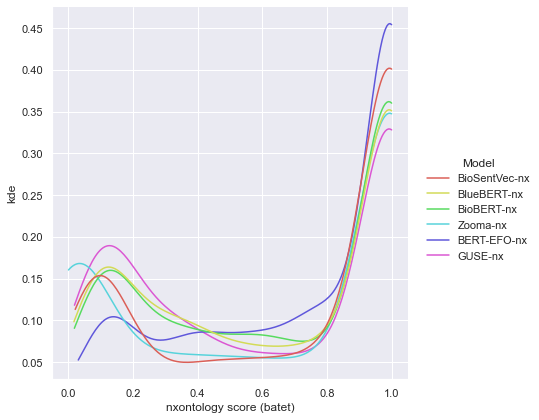

In [23]:
# melt data for plots
#ebi_df_merge = ebi_df
#print(ebi_df_merge.head())

print(ebi_df_merge.describe())
print(ebi_df_merge.shape)
nx_list = ['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx','BERT-EFO-nx','GUSE-nx']

#ebi_df_merge.reset_index(inplace=True)
print(ebi_df_merge.head())
ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=nx_list)
#ebi_df_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=['BioSentVec-nx','BlueBERT-nx','BioBERT-nx','Zooma-nx'])
ebi_df_melt.rename(columns={'variable':'Model'},inplace=True)
#print(ebi_df_melt.head())


# violin plot
#ax = sns.violinplot(x="variable", y="value", inner='quartile', data=ebi_df_melt, cut=0)
#ax.set_title('EFO distance', fontsize=16);
#fig = ax.get_figure()
#fig.savefig(f"output/all-nx.pdf")

plot_kind="kde"
ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, cut=0, palette=pallete, height=6)
#ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, palette=pallete, height=6,kde=True,stat='density')
ax.set(xlabel=f'nxontology score ({nxontology_measure})', ylabel=plot_kind)
ax.savefig(f"output/all-nx-{plot_kind}.pdf")

In [24]:
# clustermap
#g = sns.clustermap(ebi_df_merge[nx_list])
#g.savefig('output/clustermap.pdf')

In [ ]:
# pandas profiling
profile = ProfileReport(ebi_df_merge, title="Pandas Profiling Report")
#profile.to_widgets()
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/46 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# general metrics

def describe_and_plot(df,col_list,name):
    describe_df = df[col_list].describe()
    describe_df.drop(['count','max'],inplace=True)
    describe_df.reset_index(inplace=True)
    print(describe_df)
    describe_df_melt = pd.melt(describe_df, id_vars = ['index'])

    g = sns.catplot(
        data=describe_df_melt, kind="bar",
        x="index", y="value", hue="variable",
         palette=pallete, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("", name)
    g.legend.set_title("")
    g.savefig(f'output/{name}-describe.pdf')
    
describe_and_plot(ebi_df_merge,nx_list,'nxontology')
ranking_list = ['BioSentVec-rank','BlueBERT-rank','BioBERT-rank','BERT-EFO-rank','GUSE-rank']
describe_and_plot(ebi_df_merge,ranking_list,'ranking')

In [ ]:
print(ebi_df_melt.head())

In [ ]:
ebi_df_ranking_melt = pd.melt(ebi_df_merge, id_vars=['query'], value_vars=ranking_list)
ebi_df_ranking_melt.rename(columns={'variable':'Model'},inplace=True)
print(ebi_df_ranking_melt.head())

# violin
#ax = sns.violinplot(x="variable", y="value", inner='quartile', data=ebi_df_ranking_melt, cut=0)
#ax.set_title('EFO ranking position', fontsize=16);
#ax.set_yscale("log")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#fig = ax.get_figure()

# density
ax = sns.displot(x="value", hue="Model", data=ebi_df_ranking_melt, kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
#ax = sns.kdeplot(x="value", hue="Model", data=ebi_df_ranking_melt, cut=0, palette=pallete, cumulative=True)
#ax = sns.displot(x="value", hue="Model", data=ebi_df_melt, kind=plot_kind, palette=pallete, height=6,kde=True,stat='density')
#ax.set(xlabel=f'ranking distance', ylabel=plot_kind).set(xscale ='log')
ax.set(xlabel=f'ranking distance', ylabel=plot_kind)
#ax.set_xscale("log")
ax.savefig(f"output/all-ranking-kde.pdf")


In [ ]:
# check some things
# number of nx value of 1 for each model
modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
    {'name':'BERT-EFO','model':'BERT-EFO'}
    ]
#print(modelData)
print(ebi_df_merge.shape)
print(ebi_df_merge.head())
ebi_df_merge = ebi_df_merge.drop_duplicates(subset=['query','id'])
print(ebi_df_merge.shape)
for m in modelData:
    print(m)
    nx1 = ebi_df_merge[ebi_df_merge[f"{m['name']}-nx"]==1].shape[0]
    ranking0 = ebi_df_merge[ebi_df_merge[f"{m['name']}-rank"]==0].shape[0]
    print(nx1,ranking0)
#print(ebi_df_merge[ebi_df_merge['BERT-EFO-nx']==1].shape)
#print(ebi_df_merge[ebi_df_merge['BERT-EFO-manual-pos']==0].shape)
#print(ebi_df_merge.head())